In [38]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import hypernetx as hnx
import networkx as nx
import random
import seaborn as sns
import community

## Set up. 
dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_hypergraphSimulations/getMultiwayInteractions_fromBPChains/'
runDir = 'expectedReadCutoffEvaluation_v0/'
plotDir = f'{dataDir}{runDir}Plots_sample1_10kChains_600_750_3/'
outDir = f'{dataDir}{runDir}dfs_sample1_10kChains_600_750_3/'

import sys
sys.path.append('/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/v0.analysis/scripts/pythonScripts/functions/')
from chains import dictToDF, dfToDict
from incidenceToProjection import makeHiC_fromInc
from edgeWeightFormulations import finalBounded

In [2]:
numFiles = 10000
with open(f'{dataDir}makeHyperGraphDict/10k_sample1/hyperEdges_3_600_750_final_chains.pkl','rb') as f:
    hpEdges = pickle.load(f)

In [3]:
hpKeys = [k for k in hpEdges.keys()]
hpKeys_split = [k.split("_") for k in hpEdges.keys()]
keyCard = [len(item) for item in hpKeys_split]

In [129]:
card = 5
coSimFile = pd.read_csv(f'{outDir}cosineSim_card{card}.csv',sep = "\t")
wDistFile = pd.read_csv(f'{outDir}wDist_card{card}.csv',sep = "\t")
eDistFile = pd.read_csv(f'{outDir}eDist_card{card}.csv',sep = "\t")
empDistFile = pd.read_csv(f'{outDir}empDist_card{card}.csv',sep = "\t")

In [130]:
minReadCutoffStats = pd.read_pickle(f'{outDir}_card{card}.pkl')
minReadCutoffStats

count    3.169943e+06
mean     1.451546e+01
std      2.845131e+01
min      1.000000e+00
25%      3.000000e+00
50%      7.000000e+00
75%      1.500000e+01
max      2.225000e+03
dtype: float64

In [131]:
print(coSimFile.shape)
coSimFile.head()

(2000000, 6)


,5Sub2,5Sub3,5Sub4,Edge_ix,ReadSupport,Status
0,0.961263,0.857928,0.912796,5332439,1,0
1,0.992694,0.862619,0.451955,2032586,91,1
2,0.984224,0.981757,0.986381,4980351,3,0
3,0.700033,0.853089,0.573918,3450409,1,1
4,0.988653,0.990349,0.961387,4371201,3,0


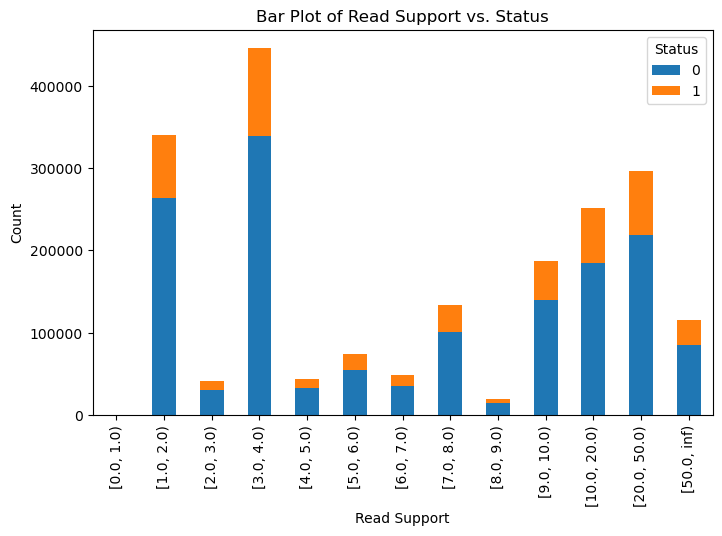

In [132]:
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, float('inf')]
empDistFile['ReadSupportBin'] = pd.cut(empDistFile['ReadSupport'], bins=bins, right=False)
grouped_empDist = empDistFile.groupby(['ReadSupportBin', 'Status']).size().unstack(fill_value=0)

# Plot the bar plot
ax = grouped_empDist.plot(kind='bar', stacked=True, figsize=(8, 5))

# Set labels and title
ax.set_xlabel('Read Support')
ax.set_ylabel('Count')
ax.set_title('Bar Plot of Read Support vs. Status')

# Show the plot
plt.show()

In [133]:
filteredEmpDist = eDistFile[eDistFile['ReadSupport'] > 3]
filteredCoSim = coSimFile[coSimFile['ReadSupport'] > 3]

In [141]:
agreement_status = ["Agree:Interesting" if v1 == 1 and v2 == 1 else 
                    "empDist only" if v1 == 1 else "cosine only" if v2 == 1 
                    else "Expected" for 
                    v1, v2 in zip(filteredEmpDist['Status'], filteredCoSim['Status'])]

In [21]:
# agreement_status = ["Agree:Interesting" if v1 == 1 and v2 == 1 else 
#                     "CoSim only" if v1 == 1 else "WDist only" if v2 == 1 
#                     else "Expected" for 
#                     v1, v2 in zip(coSimFile['Status'], wDistFile['Status'])]

In [144]:
print(len(agreement_status))
consensusIx = [coSimFile['Edge_ix'][ix] for ix,x in enumerate(agreement_status) if x == "Agree:Interesting"]
print(len(consensusIx))
randList = random.sample(range(coSimFile.shape[0]),len(consensusIx))

subsetKeys = [hpKeys[ix] for ix in consensusIx]
subsetKeyCard = [keyCard[ix] for ix in consensusIx]

1171905
56450


In [120]:
# card = 7
# coSim = pd.read_csv(f'{outDir}/empDist_card{card}.csv',sep = "\t")  ### note the label discrepancy. was in a rush
# toKeep = list(coSim[coSim['Status'] == 1]['Edge_ix'])
# randList = random.sample(range(coSim.shape[0]),len(toKeep))

# subsetKeys = [hpKeys[ix] for ix in toKeep]
# subsetKeyCard = [keyCard[ix] for ix in toKeep]

# print(len(toKeep))

8967


In [108]:
def sort_key(item):
    return int(item.split(':')[1])

def dictToDF(hpDict):
    """Finally, takes in a dict and converts to incidence DF 
    for hypergraph construction. We can implement pruning based on
    heuristics later"""
    indices = list(set(flatten([key.split('_') for key in hpDict.keys()])))
    if isinstance(indices[0],str) and ":" in indices[0]:
        sorted_ix = sorted(indices, key=sort_key)
    else:
        sorted_ix = indices.sort()
    columns = []
    colnames = []
    counter = 0

    for key, value in hpDict.items():
        counter+=1
        col_ix = key.split('_')
        column = pd.Series([0] * len(sorted_ix),index = sorted_ix)  # Initialize row with zeros
        column[col_ix] = 1
        colName = f"Read{counter}:{value}"
        colnames.append(colName)
        columns.append(column)

    df = pd.concat(columns,axis=1)
    df.columns = colnames
    return(df)

In [146]:
subsetDict = {key: hpEdges[key] for key in subsetKeys}

In [147]:
subset_incDF = dictToDF(subsetDict)

In [150]:
finalBoundedScores = [finalBounded(list(subset_incDF[c])) for c in subset_incDF.columns]

In [151]:
rsubsetKeys = [hpKeys[ix] for ix in randList]
rsubsetKeyCard = [keyCard[ix] for ix in randList]
rsubsetDict = {key: hpEdges[key] for key in rsubsetKeys}
rsubset_incDF = dictToDF(rsubsetDict)

randomBoundedScores = [finalBounded(list(rsubset_incDF[c])) for c in rsubset_incDF.columns]

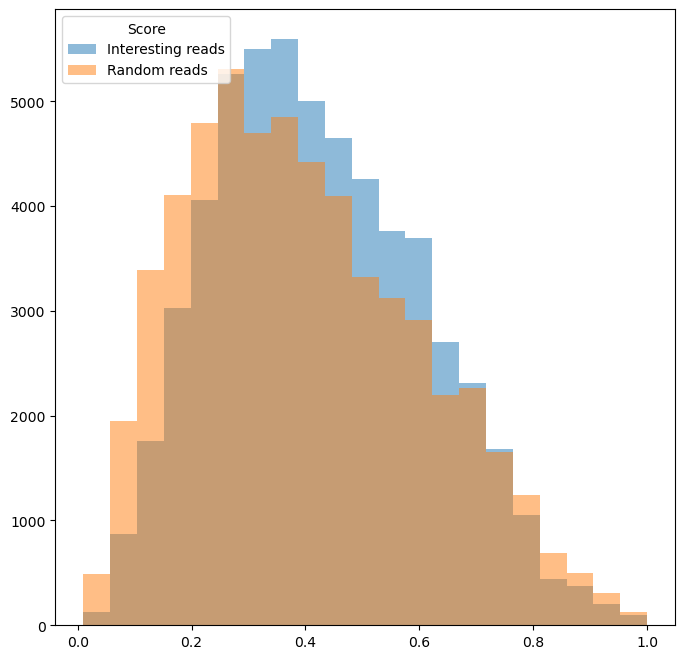

In [152]:
plt.hist(finalBoundedScores,bins = 21,alpha =0.5)
plt.hist(randomBoundedScores,bins = 21,alpha =0.5)
plt.legend(title="Score",loc="upper left",labels = ("Interesting reads","Random reads"))

In [170]:
cutoff = 0.95
interestingEdges = [i for i,x in enumerate(finalBoundedScores) if x > cutoff]
highInterestSubset_incDF = subset_incDF.iloc[:,interestingEdges]
highInterestSubset_incDF.shape

(100, 95)

In [171]:
projMat = makeHiC_fromInc(highInterestSubset_incDF)

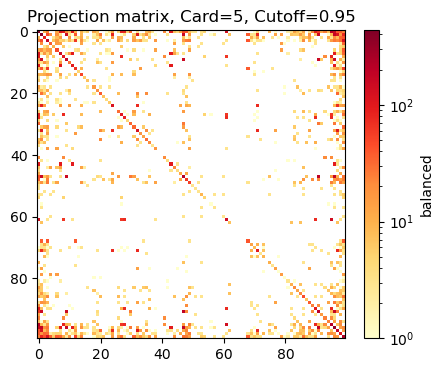

In [172]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(6, 4))
im = plt.imshow(projMat, cmap="YlOrRd",norm = LogNorm())
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title(f"Projection matrix, Card={card}, Cutoff={cutoff}")
plt.show()

In [173]:
highInterestSubsetDict = {}
highInterestSubsetDict = dfToDict(highInterestSubset_incDF,highInterestSubsetDict)

In [174]:
highInterestSubsetDict.keys()

#filteredEmpDist.iloc[13][['Edge_ix','ReadSupport']]

dict_keys(['Bin10:14_Bin70:74_Bin135:139_Bin155:159_Bin495:499', 'Bin0:4_Bin130:134_Bin140:144_Bin355:359_Bin485:489', 'Bin10:14_Bin345:349_Bin355:359_Bin445:449_Bin495:499', 'Bin0:4_Bin15:19_Bin35:39_Bin110:114_Bin490:494', 'Bin5:9_Bin245:249_Bin425:429_Bin475:479_Bin490:494', 'Bin5:9_Bin120:124_Bin160:164_Bin355:359_Bin485:489', 'Bin0:4_Bin410:414_Bin450:454_Bin460:464_Bin475:479', 'Bin0:4_Bin90:94_Bin420:424_Bin470:474_Bin490:494', 'Bin15:19_Bin70:74_Bin245:249_Bin475:479_Bin490:494', 'Bin15:19_Bin60:64_Bin165:169_Bin485:489_Bin495:499', 'Bin0:4_Bin140:144_Bin305:309_Bin450:454_Bin475:479', 'Bin5:9_Bin20:24_Bin350:354_Bin450:454_Bin495:499', 'Bin5:9_Bin20:24_Bin90:94_Bin100:104_Bin490:494', 'Bin0:4_Bin10:14_Bin30:34_Bin425:429_Bin480:484', 'Bin0:4_Bin45:49_Bin150:154_Bin460:464_Bin490:494', 'Bin5:9_Bin100:104_Bin160:164_Bin175:179_Bin485:489', 'Bin20:24_Bin235:239_Bin265:269_Bin300:304_Bin495:499', 'Bin15:19_Bin105:109_Bin160:164_Bin240:244_Bin495:499', 'Bin10:14_Bin25:29_Bin245:249

In [181]:
#hpKeys.index('Bin160:164_Bin265:269_Bin210:214_Bin215:219')
hpKeys.index('Bin5:9_Bin120:124_Bin160:164_Bin355:359_Bin485:489')

6554003

In [183]:
empDistFile[empDistFile['Edge_ix'] == 6554003]

,5Sub2,5Sub3,5Sub4,Edge_ix,ReadSupport,Status,ReadSupportBin
61438,0.974066,1.094114,0.962773,6554003,75,1,"[50.0, inf)"


In [24]:
edgeIx_rs = [list(filteredEmpDist.iloc[i][['Edge_ix','ReadSupport']]) for i in range(filteredEmpDist.shape[0])]
edge_rs = {hpKeys[a[0]]:a[1] for a in edgeIx_rs}

TypeError: list indices must be integers or slices, not float

In [97]:
[(subsetKeys[i],edge_rs[subsetKeys[i]]) for i in interestingEdges[0:10]]

[('Bin15:19_Bin65:69_Bin75:79_Bin95:99_Bin185:189_Bin205:209_Bin210:214', 3),
 ('Bin60:64_Bin95:99_Bin105:109_Bin185:189_Bin190:194_Bin195:199_Bin380:384',
  3),
 ('Bin160:164_Bin195:199_Bin395:399_Bin465:469_Bin470:474_Bin475:479_Bin480:484',
  9),
 ('Bin35:39_Bin95:99_Bin170:174_Bin185:189_Bin190:194_Bin200:204_Bin220:224',
  9)]

# choosing the following random read:
'Bin35:39_Bin95:99_Bin170:174_Bin185:189_Bin190:194_Bin200:204_Bin220:224'

## How do we find differential edges?

In [ ]:
sample2_ir = highInterestSubset_incDF

## other visualization methods

In [13]:
print(highInterestSubset_incDF.shape)
def sort_key(item):
    return int(item.split(':')[1])
binIDs = list(highInterestSubset_incDF.index)
sorted_binIDs = sorted(binIDs, key=sort_key)
highInterestSubset_incDF = highInterestSubset_incDF.reindex(index = sorted_binIDs)

(100, 458)


/gpfs/commons/home/ajoglekar/.conda/envs/noush_base/envs/hypergraph_poreC/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


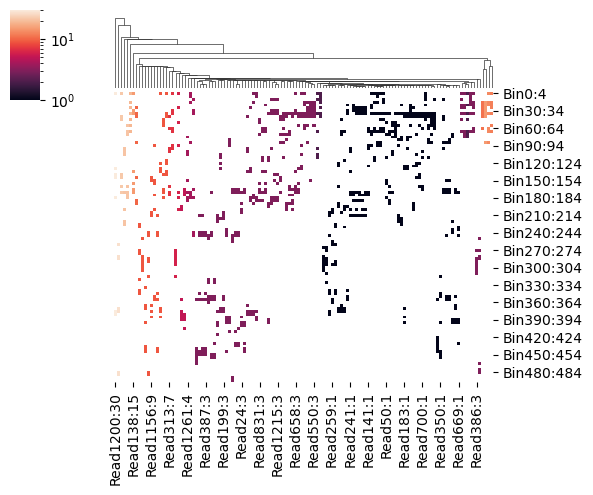

In [56]:
# plt.figure(figsize=(6, 4))
# im = plt.imshow(highInterestSubset_incDF, cmap="YlOrRd")
# plt.colorbar(im, fraction=0.046, pad=0.04);
# plt.title(f"Inc DF, Card={card}, Cutoff={cutoff}")
# plt.show()

readSupport = np.array([int(r.split(":")[1]) for r in highInterestSubset_incDF.columns])
incDFByRS = highInterestSubset_incDF.mul(readSupport.squeeze(), axis=1)

sns.clustermap(incDFByRS,figsize=(6, 5),
               row_cluster=False,
               norm = LogNorm())

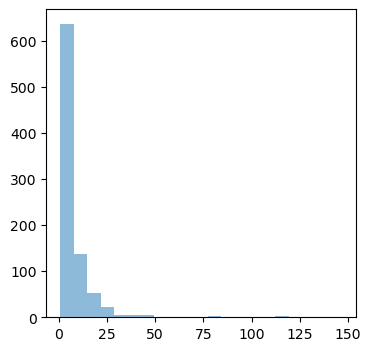

In [26]:
readSupport = [int(r.split(":")[1]) for r in highInterestSubset_incDF.columns]
plt.figure(figsize=(4,4))
plt.hist(readSupport,bins = 21,alpha =0.5)
plt.show()

In [14]:
highInterestSubset_incDF.index = ["Bin"+str((int(i.split(":")[1])+1)//5) for i in highInterestSubset_incDF.index]
HIS = hnx.Hypergraph.from_incidence_dataframe(highInterestSubset_incDF)
weights = pd.Series([finalBoundedScores[i] for i in interestingEdges], index = highInterestSubset_incDF.columns)

for e in HIS.edges:
    HIS.edges[e].weight = weights[e]

# hnx.draw(HIS)

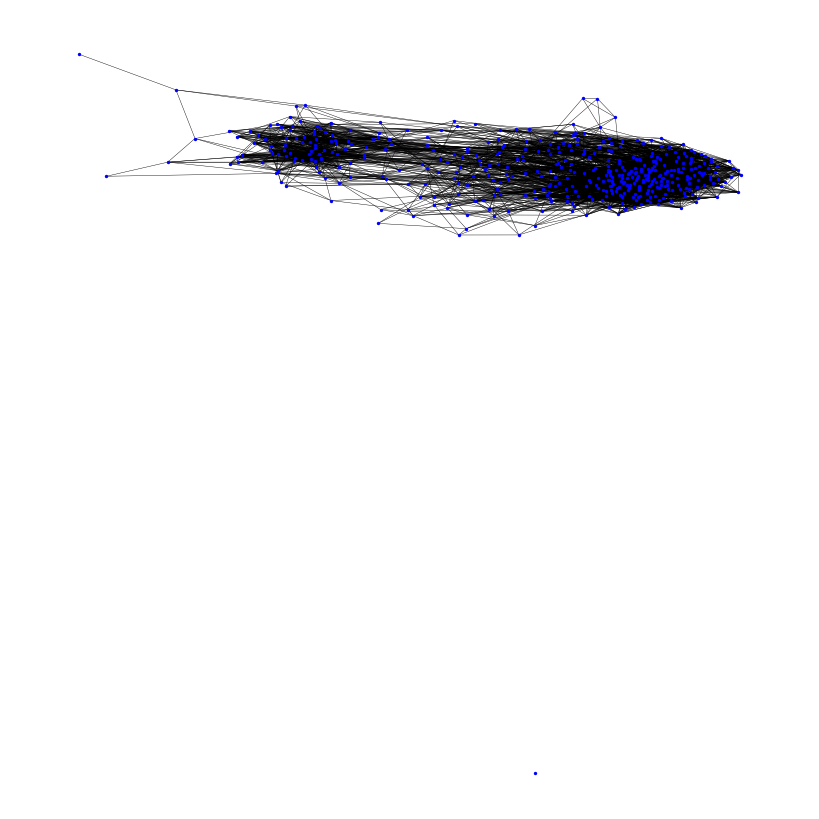

In [17]:
l = HIS.get_linegraph(s = 3)
nx.draw(l,node_size = 2, node_color = "blue",width = 0.3)

In [31]:
highInterestSubset_incDF.index = ["Bin"+str((int(i.split(":")[1])+1)//5) for i in highInterestSubset_incDF.index]
weights = pd.Series([finalBoundedScores[i] for i in interestingEdges], index = highInterestSubset_incDF.columns)
highIntAndExpr = [i for i,x in enumerate(readSupport) if x>50]
highIntAndExprSubset_incDF = highInterestSubset_incDF.iloc[:,highIntAndExpr]
highIntAndExprSubset_incDF.shape

(100, 9)

[0, 3, 9, 40, 44, 74, 75]
['Read2067:117', 'Read2640:54', 'Read2886:81', 'Read4151:117', 'Read5234:63', 'Read5936:147', 'Read6095:81', 'Read6515:64', 'Read7354:78']


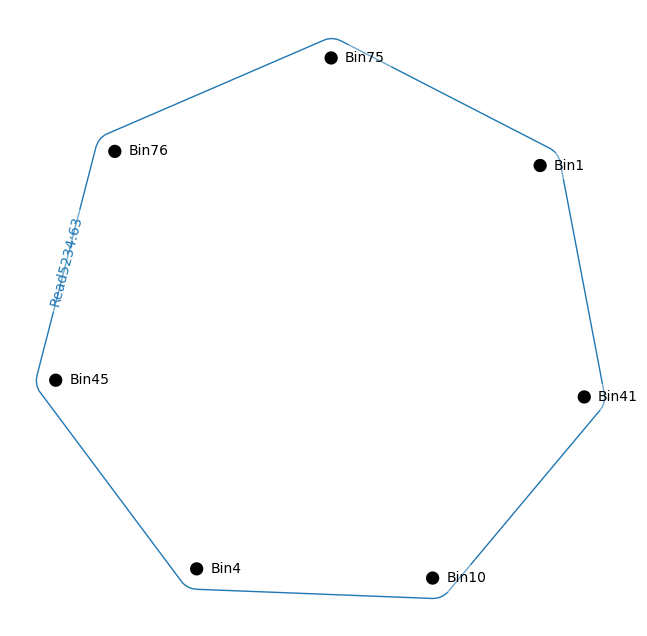

In [54]:
print([i for i,x in enumerate(list(highIntAndExprSubset_incDF['Read5234:63'])) if x == 1])
print(list(HIES.edges))

hnx.draw(HIES.restrict_to_edges(['Read5234:63']))

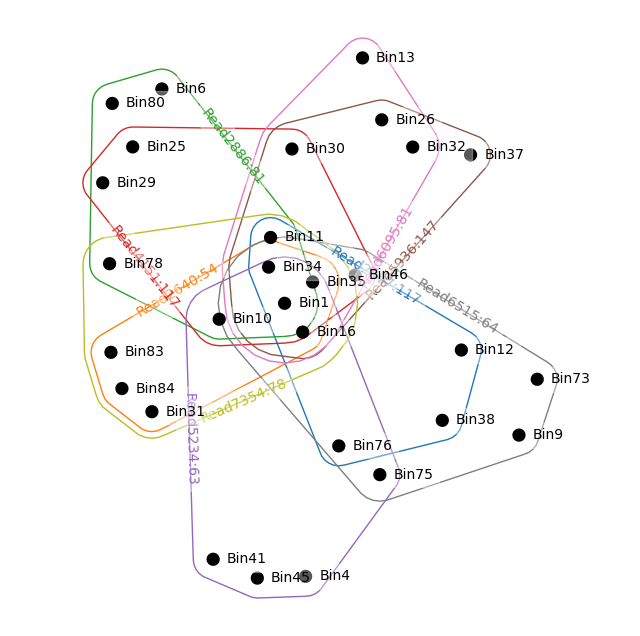

In [32]:
HIES = hnx.Hypergraph.from_incidence_dataframe(highIntAndExprSubset_incDF)

for e in HIES.edges:
    HIES.edges[e].weight = weights[e]

hnx.draw(HIES)

In [292]:
HIS.is_connected(s=3)

False

In [316]:
A, names = HIS.adjacency_matrix(s = 4, index = True)
A = A.todense()
g = HIS.get_linegraph(s = 4, edges = False)
A.shape

(100, 100)

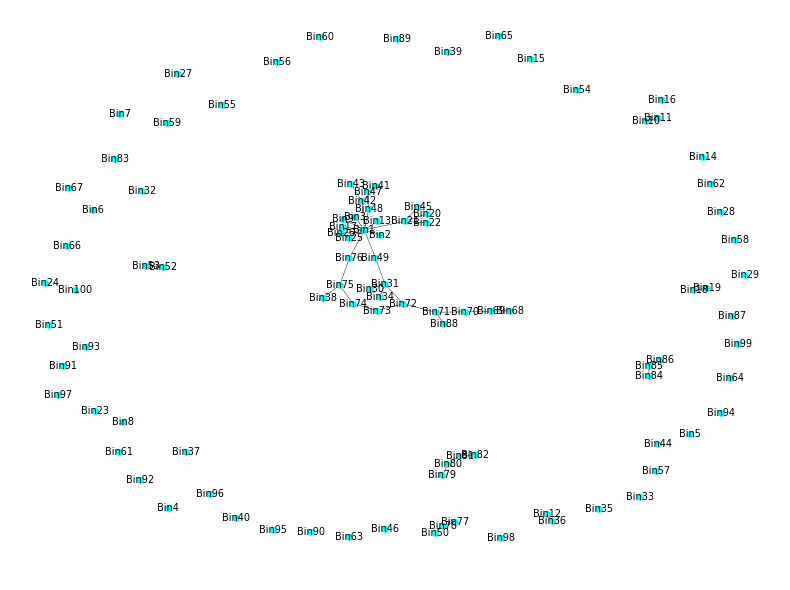

In [317]:
fig, ax = plt.subplots(figsize=(8, 6))
nx.draw(g, with_labels = True, node_size = 15, node_color = "cyan",font_size=7, width = 0.3)
plt.axis('off')
plt.tight_layout()

# Show the plot
plt.show()

/scratch/ipykernel_7421/2205544203.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis_r', max(partition1.values()) + 1)


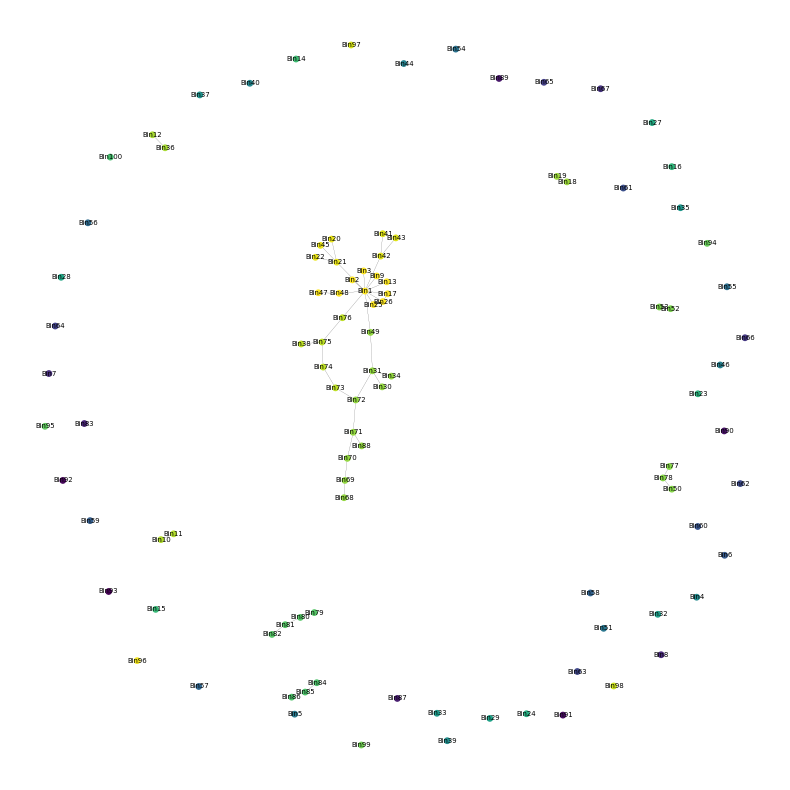

In [318]:
partition1 = community.best_partition(g)
cmap = cm.get_cmap('viridis_r', max(partition1.values()) + 1)

fig, ax = plt.subplots(figsize=(8, 8))
pos = nx.spring_layout(g)
offset = {k: (v[0], v[1] + 0.1) for k, v in pos.items()}  # Specify the desired offset
nx.draw(g, with_labels = True, node_size = 15, font_size=5, width = 0.1, cmap=cmap, node_color=list(partition1.values()))
plt.axis('off')
plt.tight_layout()

# Show the plot
plt.show()

In [305]:
graphComps = HIS.s_component_subgraphs(s = 4, edges = False,return_singletons=False, name=None)

In [306]:
nodeNames = []
for index, comp in enumerate(graphComps):
    print(index, comp.number_of_nodes())
    nodeNames.append([n for n in comp.nodes])
    print([n for n in comp.nodes])

0 32
['Bin25', 'Bin69', 'Bin13', 'Bin75', 'Bin48', 'Bin20', 'Bin45', 'Bin2', 'Bin49', 'Bin76', 'Bin30', 'Bin31', 'Bin41', 'Bin34', 'Bin38', 'Bin26', 'Bin72', 'Bin43', 'Bin21', 'Bin47', 'Bin9', 'Bin3', 'Bin1', 'Bin68', 'Bin73', 'Bin88', 'Bin74', 'Bin42', 'Bin71', 'Bin70', 'Bin22', 'Bin17']
1 2
['Bin10', 'Bin11']
2 2
['Bin12', 'Bin36']
3 2
['Bin19', 'Bin18']
4 3
['Bin50', 'Bin77', 'Bin78']
5 2
['Bin52', 'Bin53']
6 4
['Bin79', 'Bin80', 'Bin81', 'Bin82']
7 3
['Bin86', 'Bin84', 'Bin85']


In [276]:
binVec = [int(n.strip("Bin")) for n in nodeNames[0]]

In [278]:
binVec.sort()
binVec



[1, 2, 3, 9, 13, 18, 21, 26, 42, 46]

# New iteration: 2024

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.cm as cm
import random
import seaborn as sns
# import community

## Set up. 
dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_hypergraphSimulations/getMultiwayInteractions_fromBPChains/'
runDir = 'v2.evaluateExpectedVersusInteresting_sample1/'
plotDir = f'{dataDir}{runDir}Plots_sample1_10kChains_500_750_1/'
outDir = f'{dataDir}{runDir}dfs_sample1_10kChains_500_750_1/'

runDir2 = 'v2.evaluateExpectedVersusInteresting_sample2/'
plotDir2 = f'{dataDir}{runDir2}Plots_sample2_10kChains_500_750_1/'
outDir2 = f'{dataDir}{runDir2}dfs_sample2_10kChains_500_750_1/'

import sys
sys.path.append('/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/v0.analysis/scripts/pythonScripts/functions/')
from chains import dictToDF, dfToDict
from incidenceToProjection import makeHiC_fromInc
from edgeWeightFormulations import finalBounded

In [52]:
card = 4
coSimFile = pd.read_csv(f'{outDir}cosineSim_card{card}.csv',sep = "\t")
wDistFile = pd.read_csv(f'{outDir}wDist_card{card}.csv',sep = "\t")
eDistFile = pd.read_csv(f'{outDir}eDist_card{card}.csv',sep = "\t")
empDistFile = pd.read_csv(f'{outDir}empDist_card{card}.csv',sep = "\t")

In [2]:
# card = 3
# coSimFile = pd.read_csv(f'{outDir2}cosineSim_card{card}.csv',sep = "\t")
# wDistFile = pd.read_csv(f'{outDir2}wDist_card{card}.csv',sep = "\t")
# eDistFile = pd.read_csv(f'{outDir2}eDist_card{card}.csv',sep = "\t")
# empDistFile = pd.read_csv(f'{outDir2}empDist_card{card}.csv',sep = "\t")

In [53]:
print(coSimFile.shape)
coSimFile.head()

(908053, 5)


,4Sub2,4Sub3,Edge_ix,ReadSupport,Status
0,0.908680,0.885919,1456606,34,1
1,0.953521,0.912525,2293994,63,0
2,0.953535,0.904075,451946,673,0
3,0.984101,0.975606,1337697,53,0
4,0.823293,0.703582,851512,256,1


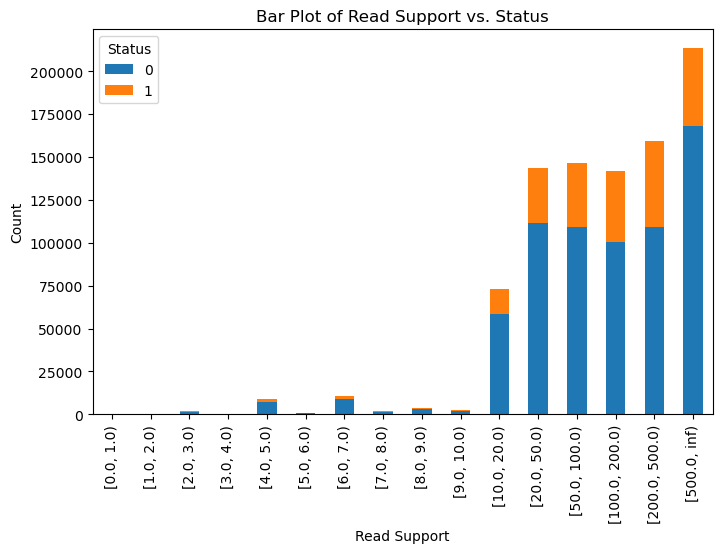

In [54]:
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 200, 500, float('inf')]
empDistFile['ReadSupportBin'] = pd.cut(empDistFile['ReadSupport'], bins=bins, right=False)
grouped_empDist = empDistFile.groupby(['ReadSupportBin', 'Status']).size().unstack(fill_value=0)

# Plot the bar plot
ax = grouped_empDist.plot(kind='bar', stacked=True, figsize=(8, 5))

# Set labels and title
ax.set_xlabel('Read Support')
ax.set_ylabel('Count')
ax.set_title('Bar Plot of Read Support vs. Status')

# Show the plot
plt.show()

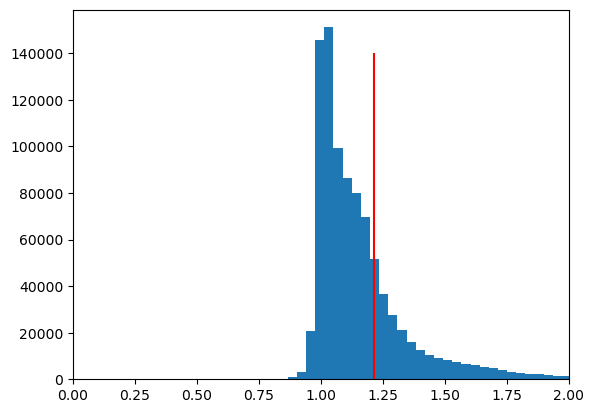

In [57]:
## I think i messed up the emp dist cutoff

def getCutoff(summaryDF,quartile):
    q = f'{quartile}%'
    cutoff = pd.Series(summaryDF['mean']).describe()[q]
    return(cutoff)

# # summary_empDist = empDistFile.filter(like="Sub").agg((np.mean,np.std),axis = 1)
summary_empDist = empDistFile.filter(like="Sub").apply(lambda row: [np.mean(row), np.std(row)], axis=1, result_type='expand')
summary_empDist.columns = ['mean','sd']
empdistCutoff = getCutoff(summary_empDist,75)
p = plt.hist(summary_empDist['mean'],bins=10000)
plt.xlim(0,2)
plt.vlines(empdistCutoff, ymin = 0, ymax=140000,colors="red")
plt.show()
empdistStatus = [1 if x else 0 for x in (summary_empDist['mean'] >= empdistCutoff)]

In [58]:
agreement_status = ["Agree:Interesting" if v1 == 1 and v2 == 1 else 
                    "CoSim only" if v1 == 1 else "empDist only" if v2 == 1 
                    else "Expected" for 
                    v1, v2 in zip(coSimFile['Status'], empdistStatus)]

Text(0.5, 0.98, '4Sub2')

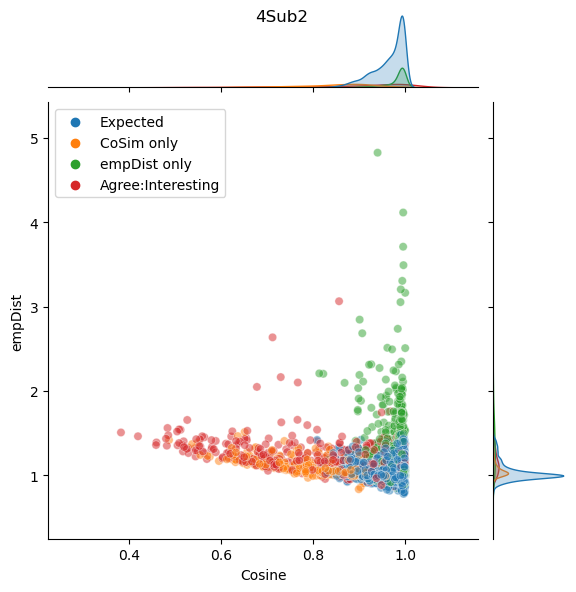

In [59]:
#fig, axes = plt.subplots(1, 2, figsize=(8, 4))

legend_order = ["Expected","CoSim only", "empDist only","Agree:Interesting"]

#plt.figure(figsize=(8, 4))
cos = coSimFile['4Sub2'][0:5000]
empDist = empDistFile['4Sub2'][0:5000]
j1 = sns.jointplot(x=cos, y=empDist, kind="scatter", hue=agreement_status[0:5000], hue_order=legend_order, alpha = 0.5)
j1.set_axis_labels('Cosine', 'empDist', fontsize=10)
j1.fig.suptitle("4Sub2")
#axes[0].set_title('5Sub2')

# cos = coSimFile['5Sub3'][0:2500]
# empDist = empDistFile['5Sub3'][0:2500]
# j2 = sns.jointplot(x=cos, y=empDist, kind="scatter", hue=agreement_status,hue_order=legend_order, alpha = 0.5)
# j2.set_axis_labels('Cosine', 'empDist', fontsize=10)
# j2.fig.suptitle("5Sub3")
# #axes[1].set_title('5Sub3')

# cos = coSimFile['5Sub4'][0:2500]
# empDist = empDistFile['5Sub4'][0:2500]
# j3 = sns.jointplot(x=cos, y=empDist, kind="scatter", hue=agreement_status, hue_order=legend_order, alpha = 0.5)
# j3.set_axis_labels('Cosine', 'empDist', fontsize=10)
# j3.fig.suptitle("5Sub4")
# # plt.tight_layout()
# # plt.show()

In [7]:
with open(f'{dataDir}v2.makeCombinedHypergraphDicts/sample1/hyperEdges_1_500_750_final_chains.pkl','rb') as f:
    hpEdges = pickle.load(f)

print("Processing all the hyperedges from pickle file")
hpKeys = [k for k in hpEdges.keys()]
print("A total of",len(hpKeys),"initial interactions")
#keyCard = [len(item) for item in hpKeys_split]

readSupport = [v[0] for v in hpEdges.values()]
chainSupport = [v[1] for v in hpEdges.values()]
readCards = [v[3] for v in hpEdges.values()]

atLeastTwoChains = [i for i,x in enumerate(chainSupport) if x >=2]
updatedDict = {hpKeys[i]:readSupport[i] for i in atLeastTwoChains}

hpKeys = [k for k in updatedDict.keys()]
hpKeys_split = [k.split("_") for k in updatedDict.keys()]
keyCard = [readCards[i] for i in atLeastTwoChains]

Processing all the hyperedges from pickle file
A total of 7649582 initial interactions


In [75]:
print(len(agreement_status))
consensusIx = [coSimFile['Edge_ix'][ix] for ix,x in enumerate(agreement_status) if x == "Agree:Interesting"]
print(len(consensusIx))
randList = random.sample(range(coSimFile.shape[0]),len(consensusIx))

subsetKeys = [hpKeys[ix] for ix in consensusIx]
subsetKeyCard = [keyCard[ix] for ix in consensusIx]

908053
118981


In [61]:
## BORING (expected) READS as control
print(len(agreement_status))
consensusIx = [coSimFile['Edge_ix'][ix] for ix,x in enumerate(agreement_status) if x == "Expected"]
print(len(consensusIx))
randList = random.sample(range(coSimFile.shape[0]),len(consensusIx))

subsetKeys = [hpKeys[ix] for ix in consensusIx]
subsetKeyCard = [keyCard[ix] for ix in consensusIx]

908053
573006


In [76]:
subsetDict = {key: updatedDict[key] for key in subsetKeys}
subset_incDF = dictToDF(subsetDict)
finalBoundedScores = [finalBounded(list(subset_incDF[c])) for c in subset_incDF.columns]

In [77]:
rsubsetKeys = [hpKeys[ix] for ix in randList]
rsubsetKeyCard = [keyCard[ix] for ix in randList]
rsubsetDict = {key: updatedDict[key] for key in rsubsetKeys}
rsubset_incDF = dictToDF(rsubsetDict)

randomBoundedScores = [finalBounded(list(rsubset_incDF[c])) for c in rsubset_incDF.columns]

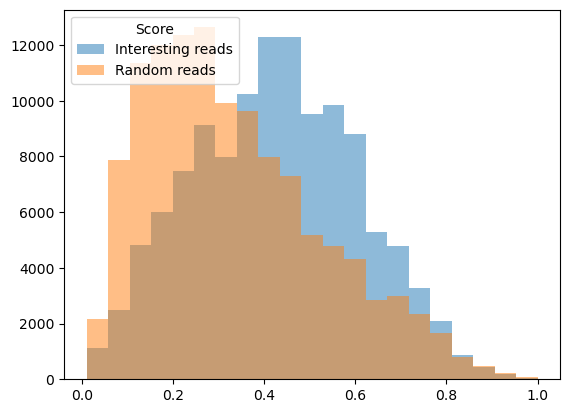

In [78]:
plt.hist(finalBoundedScores,bins = 21,alpha =0.5)
plt.hist(randomBoundedScores,bins = 21,alpha =0.5)
plt.legend(title="Score",loc="upper left",labels = ("Interesting reads","Random reads"))

In [85]:
cutoff = 0.8
interestingEdges = [i for i,x in enumerate(finalBoundedScores) if x > cutoff]
highInterestSubset_incDF = subset_incDF.iloc[:,interestingEdges]
highInterestSubset_incDF.shape

(100, 1896)

In [86]:
projMat = makeHiC_fromInc(highInterestSubset_incDF)

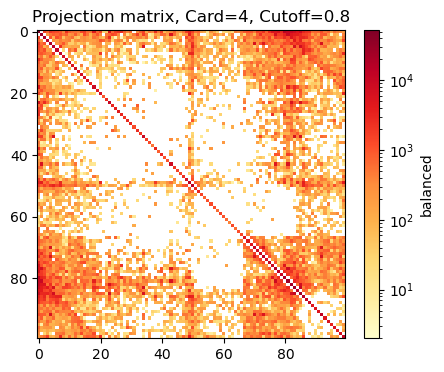

In [87]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(6, 4))
im = plt.imshow(projMat, cmap="YlOrRd",norm = LogNorm())
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title(f"Projection matrix, Card={card}, Cutoff={cutoff}")
plt.show()

### Selecting interesting read candidates

In [18]:
from statistics import median
print(len(hpEdges))
ogKeys = list(hpEdges.keys())
ogReadSupport = [v[0] for v in hpEdges.values()]
chainSupport = [v[1] for v in hpEdges.values()]
readCards = [v[3] for v in hpEdges.values()]

7649582


In [19]:
A = zip(readCards,chainSupport,ogReadSupport,ogKeys)
og_info = pd.DataFrame(A)
og_info.columns = ["card","chainSupport","readSupport","key"]

In [20]:
import statistics
from itertools import combinations

def getGM_pairwise(k):
    binIDs = [int(i.split(":")[1]) for i in k.split("_")]
    combs = list(combinations(binIDs,2))
    distances = [(item[1]-item[0]) // 5 for item in combs]
    gm = round(statistics.mean(distances)) #statistics.geometric_mean
    return(gm)

In [21]:
og_info['GM_dist'] = [getGM_pairwise(key) for key in og_info['key']]
og_info.head()

,card,chainSupport,readSupport,key,GM_dist
0,2,5080,186784,Bin0:4_Bin25:29,5
1,2,1935,63455,Bin0:4_Bin95:99,19
2,2,1573,49597,Bin0:4_Bin115:119,23
3,2,481,14408,Bin0:4_Bin385:389,77
4,2,455,12234,Bin0:4_Bin390:394,78


In [91]:
interestingReads = list(subsetDict.keys())
interesting_multichain = og_info[(og_info['key'].isin(interestingReads)) & 
        (og_info['chainSupport']>200) &
         (og_info['chainSupport']<800)]

In [92]:
interesting_multichain

,card,chainSupport,readSupport,key,GM_dist
89,4,241,25768,Bin0:4_Bin5:9_Bin30:34_Bin100:104,11
1172,4,365,37553,Bin25:29_Bin30:34_Bin35:39_Bin115:119,9
1184,4,713,58680,Bin25:29_Bin30:34_Bin35:39_Bin75:79,5
1187,4,681,57067,Bin30:34_Bin35:39_Bin40:44_Bin75:79,5
1517,4,319,27439,Bin40:44_Bin45:49_Bin50:54_Bin130:134,9
...,...,...,...,...,...
409506,4,240,16311,Bin185:189_Bin210:214_Bin215:219_Bin220:224,4
416577,4,255,17887,Bin0:4_Bin5:9_Bin40:44_Bin85:89,10
442799,4,273,31783,Bin420:424_Bin425:429_Bin430:434_Bin445:449,3
483024,4,234,13905,Bin110:114_Bin115:119_Bin120:124_Bin165:169,6


In [90]:
og_info[(og_info['key'].isin(interestingReads)) & 
        (og_info['chainSupport']>100)].head(15)

,card,chainSupport,readSupport,key,GM_dist
89,4,241,25768,Bin0:4_Bin5:9_Bin30:34_Bin100:104,11
1172,4,365,37553,Bin25:29_Bin30:34_Bin35:39_Bin115:119,9
1184,4,713,58680,Bin25:29_Bin30:34_Bin35:39_Bin75:79,5
1187,4,681,57067,Bin30:34_Bin35:39_Bin40:44_Bin75:79,5
1517,4,319,27439,Bin40:44_Bin45:49_Bin50:54_Bin130:134,9
1527,4,514,39441,Bin40:44_Bin45:49_Bin50:54_Bin85:89,5
1528,4,504,33640,Bin40:44_Bin45:49_Bin50:54_Bin90:94,5
1670,4,248,16958,Bin130:134_Bin165:169_Bin170:174_Bin175:179,5
1674,4,284,19711,Bin140:144_Bin165:169_Bin170:174_Bin175:179,4
1824,4,960,63448,Bin50:54_Bin55:59_Bin60:64_Bin70:74,2


## Interesting reads to work with:
1. Sample1 Card3    "Bin245:249_Bin260:264_Bin430:434" 203
2. Sample1 Card3    "Bin245:249_Bin255:259_Bin290:294" 232
3. Sample1 Card4    "Bin60:64_Bin65:69_Bin70:74_Bin130:134" 300
4. Sample1 Card4    "Bin0:4_Bin5:9_Bin40:44_Bin85:89" 255

5. Sample2 Card3    "Bin0:4_Bin10:14_Bin140:144"    274
6. Sample2 Card3    "Bin0:4_Bin5:9_Bin30:34" 3446
7. Sample2 Card4    "Bin50:54_Bin55:59_Bin65:69_Bin105:109" 254
8. Sample2 Card4    "Bin5:9_Bin30:34_Bin35:39_Bin40:44" 1181


## Controls:
1. Sample1 Card3    "Bin0:4_Bin10:14_Bin30:34"  1647
2. Sample1 Card3    "Bin0:4_Bin25:29_Bin390:394" 101
3. Sample1 Card4    "Bin5:9_Bin25:29_Bin95:99_Bin100:104" 209
4. Sample1 Card4    "Bin10:14_Bin20:24_Bin25:29_Bin35:39" 947

5. Sample2 Card3    "Bin55:59_Bin65:69_Bin75:79"  1535
6. Sample2 Card3    "Bin5:9_Bin45:49_Bin150:154" 270
7. Sample2 Card4    "Bin60:64_Bin65:69_Bin80:84_Bin85:89" 1028
8. Sample2 Card4    "Bin190:194_Bin195:199_Bin200:204_Bin215:219" 274